In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('dataset_devcamp.csv')
df.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000,133980.000000
mean,94818.230079,9199.422511,254761.132468,205.977719,218.694914,0.094096,0.132893,51.770645
std,54769.102250,615.591692,85547.340828,103.369888,110.710208,0.291964,0.339460,60.623927
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,47417.750000,8562.000000,217217.000000,129.675000,133.237500,0.000000,0.000000,20.000000
50%,94815.500000,9371.000000,222087.000000,197.362500,205.912500,0.000000,0.000000,35.000000
75%,142246.250000,9731.000000,245338.000000,232.987500,234.412500,0.000000,0.000000,62.000000
max,189717.000000,9984.000000,679023.000000,533.662500,533.662500,1.000000,1.000000,2876.000000


In [3]:
df2 = df[df['total_price']>df['base_price']]

In [4]:
(len(df2)/len(df))*100

2.264517092103299

In [5]:
len(df['sku_id'].unique())

28

In [6]:
len(df['store_id'].unique())

76

In [7]:
sku_price_comparison = df.pivot_table(
    index="sku_id",
    columns="store_id",
    values="base_price",
    aggfunc="mean"  # or use max/min if needed
)
sku_price_comparison['min_price_across_stores'] = sku_price_comparison.min(axis=1)
sku_price_comparison['max_price_across_stores'] = sku_price_comparison.max(axis=1)

sku_price_comparison

store_id,8023,8058,8063,8091,8094,8095,8121,8218,8222,8317,...,9879,9880,9881,9890,9909,9954,9961,9984,min_price_across_stores,max_price_across_stores
sku_id,,,,,,,,,,,,,,,,,,,,,
216233,131.314978,131.032435,127.058405,129.484591,125.768534,131.106142,125.467565,123.323922,131.462392,126.395043,...,124.282112,124.939332,130.043534,131.106142,132.316164,125.731681,131.222845,124.650647,121.505819,132.316164
216418,106.371336,106.850431,81.722522,105.370151,87.262823,102.876401,81.163578,80.518642,105.935237,NaN,...,87.053987,85.733405,103.840733,105.517565,104.958621,NaN,103.638039,86.857435,74.308836,109.295043
216419,106.598599,106.660022,81.532112,105.388578,87.698922,102.692134,NaN,80.672198,106.512608,81.624246,...,86.439763,85.721121,104.110991,105.443858,104.970905,81.568966,104.467241,86.697737,78.166164,109.252047
216425,129.238901,129.472306,NaN,130.958728,124.392672,128.980927,126.063362,124.103987,130.584052,126.198491,...,124.036422,125.965086,129.834698,130.854310,130.350647,126.683728,131.106142,126.474892,123.379203,131.456250
217217,NaN,NaN,230.051509,NaN,228.202694,NaN,227.410345,227.576185,NaN,228.638793,...,NaN,227.938578,NaN,NaN,NaN,231.298384,NaN,NaN,227.410345,309.378556
217390,160.754741,160.822306,157.401078,163.058082,160.257220,160.767026,153.709591,154.643211,160.754741,157.745043,...,156.049784,154.219397,160.975862,161.510237,162.818534,158.113578,160.963578,160.496767,153.513039,163.058082
217777,NaN,NaN,230.088362,NaN,232.692672,NaN,230.266487,NaN,NaN,NaN,...,230.352478,229.873384,NaN,NaN,NaN,NaN,NaN,NaN,227.932435,306.651401
219009,213.977263,212.349569,201.741918,222.944935,203.848707,213.799138,203.781142,201.748060,217.963578,203.117780,...,205.734375,204.180388,217.232651,218.608513,219.947522,201.158405,214.788039,205.464116,191.257112,222.944935
219029,324.525323,325.655496,295.300539,327.473599,311.718750,325.594073,294.999569,295.030280,326.220582,295.460237,...,312.818211,311.810884,324.936853,326.275862,326.847091,295.355819,325.452802,312.738362,234.424784,327.473599


In [8]:
len(df['week'].unique())

116

In [9]:
df['week'] = pd.to_datetime(df['week'])


In [10]:
weekly_trends = df.groupby('week').agg({
    'base_price': 'mean',
    'total_price': 'mean',
    'units_sold': 'mean',
    'is_featured_sku': 'mean',
    'is_display_sku': 'mean'
}).reset_index()


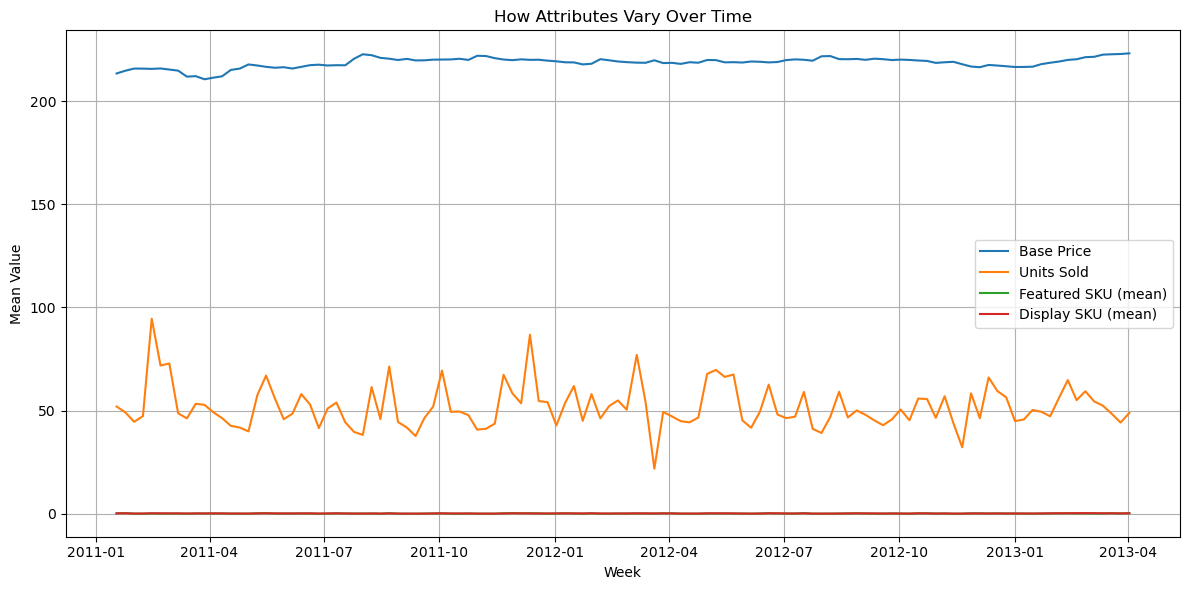

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(weekly_trends['week'], weekly_trends['base_price'], label='Base Price')
plt.plot(weekly_trends['week'], weekly_trends['units_sold'], label='Units Sold')
plt.plot(weekly_trends['week'], weekly_trends['is_featured_sku'], label='Featured SKU (mean)')
plt.plot(weekly_trends['week'], weekly_trends['is_display_sku'], label='Display SKU (mean)')
plt.legend()
plt.title("How Attributes Vary Over Time")
plt.xlabel("Week")
plt.ylabel("Mean Value")
plt.grid(True)
plt.tight_layout()
plt.show()


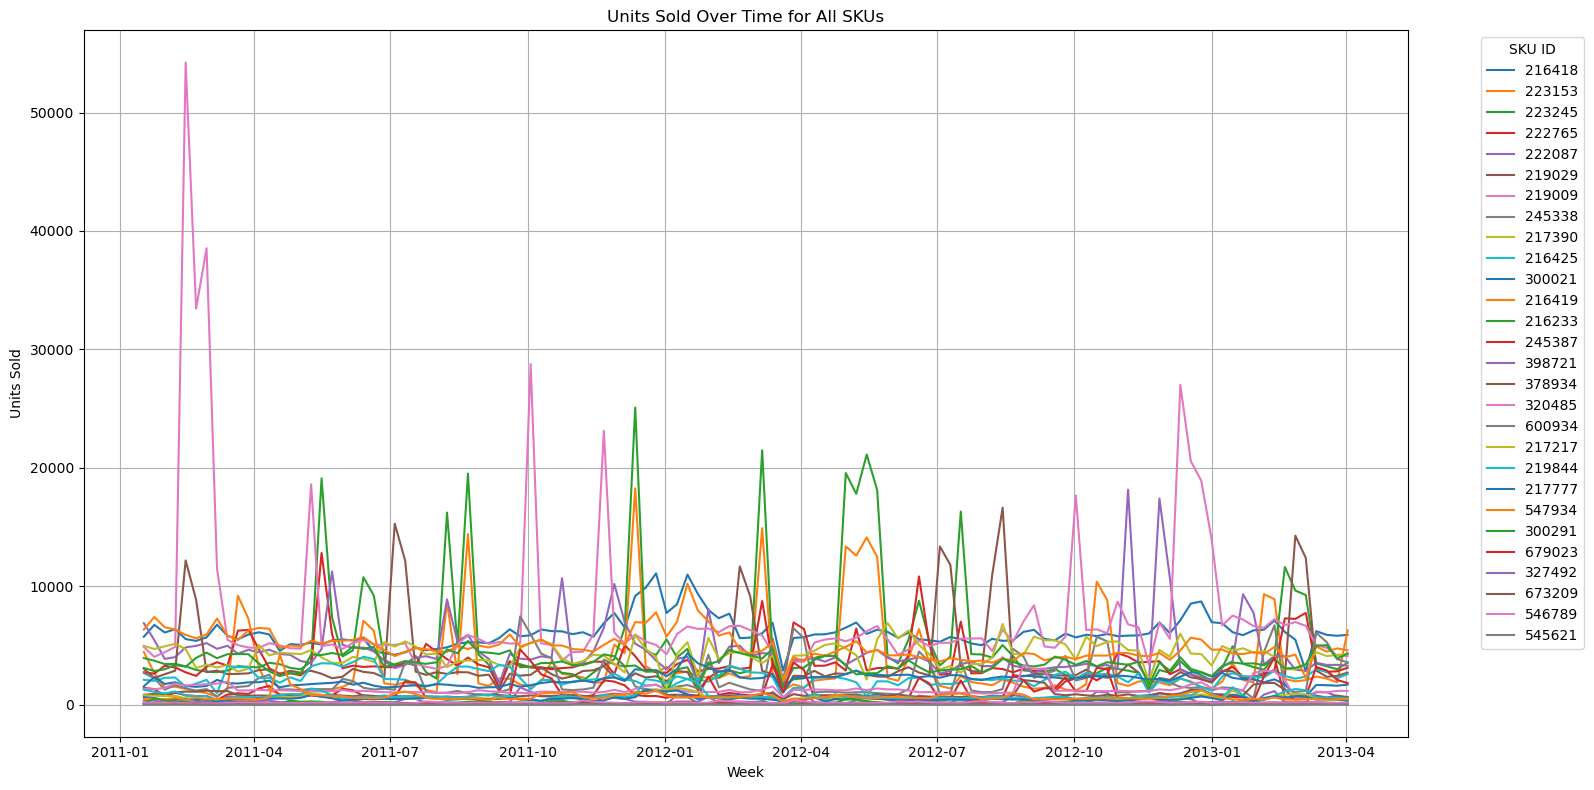

In [18]:
import os

output_dir = "sku_plots"
os.makedirs(output_dir, exist_ok=True)

# Get unique sku_ids
sku_ids = df['sku_id'].unique()

# Set up the plot
plt.figure(figsize=(16, 8))

# Plot each SKU's time series
for sku in sku_ids:
    sku_df = df[df['sku_id'] == sku]
    grouped = sku_df.groupby('week').agg({
        'units_sold': 'sum'
    }).reset_index()
    
    plt.plot(grouped['week'], grouped['units_sold'], label=str(sku))  # Use SKU as label

# Add plot labels
plt.title("Units Sold Over Time for All SKUs")
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.legend(title="SKU ID", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()